# Exercise 2

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

# Problem Overview

In this problem we will find eigenvalues of the 1H Schrödinger equation using numerical methods.

The time-independent Schrödinger equation in 1D can be written :

\begin{equation}
H \psi = E \psi \tag{1}
\end{equation}

Where the Hamiltonian $H$ is given by 

$$
H = \frac{-\hbar^2}{2m}\frac{d^2}{dx^2} + V \tag{2}
$$

In order to find numerical solutions, we can divide the spatial dimension into $N$ discrete points, $x_i$, and evaluate $\psi$ at each one.  Given this, equation 1 becomes a matrix equation, with $\psi$ an $N$-dimensional vector, and $H$ an $(N \times N)$ matrix.  We can then find the eigenvalues and eigenfunctions of the equation using numerical methods.

In order to define the matrix $H$, we can use a discrete approximation of the 2nd derivative :
$$
\frac{d^2}{dx^2} \psi(x_i) \rightarrow \frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{(\Delta x)^2}
$$

where $(\Delta x)$ is the distance between discrete points $x_i$. We will choose dimensionless units for each problem, where $x$ is measured in terms of a length $a$, and $E$ is therefore measured in units of $\frac{\hbar^2}{2m a^2}$.  We can therefore write the kinetic energy term of the Hamiltonian as a "tri-diagonal" matrix $H$, which has the leading diagonal :

$$D_{i,i} = \frac{2}{(\Delta x)^2}$$

and the diagonals above and below this are :

$$D_{i,i+1} = D_{i,i-1} = \frac{-1}{(\Delta x)^2}$$

The potential term $V \psi$ can be represented by a matrix where the leading diagonal is the potential evaluated at the $i$-th point in space, $V_{i,i} = V(x_i)$, and all other entries are zero.

Given a potential, we construct the Hamiltonian matrix, $H=H+V$, and then use a numerical method to find the eigenvalues and eigenvectors of $H$.

## Part 1

The quantum harmonic oscillator is a good example to start with, since it has exact analytic solutions. The potential is :
$$V(x) = \frac{1}{2}m \omega^2 x^2$$

If we choose to measure $x$ in units of $\sqrt{\frac{\hbar}{m \omega}}$, then $E$ will be measured in units of $\frac{1}{2}\hbar \omega$, and the potential can be written :

$$V(x_i) = i^2 (\Delta x)^2 = x_i^2$$

You should write a function which takes as argument a discrete set of space points, $x_i$, (ie. an array), and returns the potential at each point, $V_i$ (another array).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, sparse, integrate
import sys




def potential_qho(x):
    """
    Quantum Harmonic Oscillator potential function. Returns a potential for every spatial point.
    """
    v = list(map((lambda x: np.power(x, 2)), x)) #producing a potential for every point given, i use map() here as it is faster.
    return v

Now test your function by plotting the results over a suitable range of $x$.

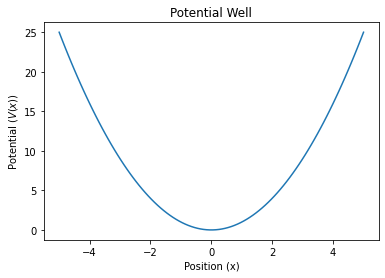

In [2]:
x_test = np.linspace(-5, 5, 100)
plt.title("Potential Well")
plt.plot(x_test, potential_qho(x_test)) 
plt.ylabel("Potential ($V(x)$)")
plt.xlabel("Position (x)")
plt.show()

# Part 2

Now write a function which, given the discrete space points $x_i$ and the potential $V_i$, constructs and returns the Hamiltonian matrix.

In [3]:
# def hamiltonian(x, v):
#     H = sparse.eye(len(x), len(x), format = 'lil') * 2
#     for i in range (len(x) - 1):
#         H[i, i+1] = -1
#         H[i+1, i] = -1
#     dx = x[1] - x[0]
#     H = H / np.power(dx, 2)
#     for i in range(len(x)):
#         H[i,i] = H[i,i] + v[i]
#     return H.toarray() OLD METHOD

def hamiltonian(x, v):
    """
    A function to generate the hamiltonian matrix. Function is given a set of spatial points with a potential function. It then contstructs a tri-diagonal matrix D, (which we use as our 
    approximation for the laplace operator) and V, a matrix constructed from the potential function. The hamiltonian is then the sum of these two matrices. The sparse hamiltonian is converted to an         array in return statement, so that standard scipy.linalg.eigh may be used instead of the sparse.linalg routines.
    """
    dx = x[1] - x[0] #increment in x
    D = sparse.diags([-1, 2, -1], [-1, 0, 1], shape = (len(x), len(x))) #our tri-diagonal matrix to approximate laplace operator 
    V = sparse.diags([0,v,0], [-1,0,1], shape = (len(x), len(x))) #potential matrix formed from our potential_qho function
    H = D/np.power(dx, 2) + V #hamiltonian matrix, with the added denominator for finite difference matrix
    return H.toarray() #using .toarray() so i can use linalg.eigh 

    



Test your function by printing the matrix it returns.  You can use small $N$ and check a few elements by hand to ensure they are correct.

In [4]:
xs = np.linspace(-2,2, 5) 
print(hamiltonian(xs, potential_qho(xs))) #small N matrix to test that it works.

[[ 6. -1.  0.  0.  0.]
 [-1.  3. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  3. -1.]
 [ 0.  0.  0. -1.  6.]]


# Part 3

Now find the first 10 eigenvalues of the quantum harmonic oscillator Hamiltonian using an appropriate scipy routine. You should use a large number of $x$ points, at least 1000, covering sufficient range that the wavefunction falls to zero at the extremities. You should compare the computed eigenvalues with the expected eigenvalues.

In [5]:
points = np.linspace(-6, 6, 2000)


def solveHam(x, v):
    """
    Function to find the eigenvalues and eigenvectors of a hamiltonian for a given x and potential, which are generated from our hamiltonian and potential_qho functions
    Returns the eigenvalues and eigenvectors in a tuple.
    """
    dx = x[1] - x[0] #x-increment
    evals, evects = linalg.eig(hamiltonian(x, v)) #solving the hamiltonian, use linalg.eigh as our hamiltonian is hermitian 
    sortindex = np.argsort(evals)
    evals = evals[sortindex]  #sorting the eigenvalues in ascending order, for some scipy routines they are not sorted
    evects = evects[:, sortindex]

    evectsNorm = np.zeros_like(evects)
    for i in range(len(x)):
        normalisationfactor = integrate.simps(evects[:,i]**2,dx=dx) # standard normalisation technique
        evectsNorm[:,i]=  evects[:,i]/np.sqrt(normalisationfactor) # normalising the eigenvectors 
    return evals, evectsNorm


eigenvalues, eigenvectors = solveHam(points, potential_qho(points))

n = 10
odd = 1
print("{:<8} {:<8} {:<8}".format("|| [n] ||", "Eigenvalue", " || Theoretical ||"))
for i in range(n):
    print("||", [i], "|| ", "{:^9}".format("%.5f"%eigenvalues[i]), " || ", '{:^9}'.format("%.5f"%odd), ' ||') #tabulate eigenvalue with proper spacing
    odd+=2






|| [n] || Eigenvalue  || Theoretical ||
|| [0] ||   1.00000   ||   1.00000   ||
|| [1] ||   2.99999   ||   3.00000   ||
|| [2] ||   4.99997   ||   5.00000   ||
|| [3] ||   6.99994   ||   7.00000   ||
|| [4] ||   8.99991   ||   9.00000   ||
|| [5] ||  10.99986   ||  11.00000   ||
|| [6] ||  12.99981   ||  13.00000   ||
|| [7] ||  14.99975   ||  15.00000   ||
|| [8] ||  16.99969   ||  17.00000   ||
|| [9] ||  18.99969   ||  19.00000   ||


Next you should plot the wavefunctions, ie. the eigenvectors.  Rather than plot the wavefunction directly, you should plot the probability density, which is given by $\psi^2$, and indicates the probability to find the particle at position $x$.

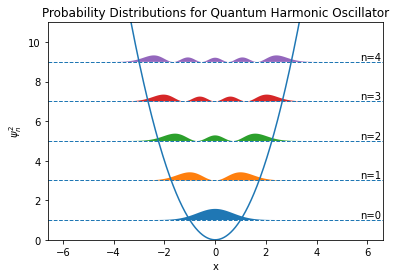

In [6]:

def plot_quantum(n, x, v, eigenvalues, eigenvectors):
    """
    Plotting function so that several probability distribution plots can be produced for different n, where n is the number of eigenvalues to plot. 
    Plots the probability distributions on top of their respective energy levels. The potential well is also plotted for visualisation.
    """
    plt.xlabel('x')
    plt.ylabel('$\psi^2_n$')
    plt.plot(x, v) #plot the potential on top to show the effect of the potential well on the wavefunctions
    plt.ylim((0, eigenvalues[n])) #limit on y-axis so that distributions can be seen clearly
    plt.title("Probability Distributions for Quantum Harmonic Oscillator")
    for i in range(n): #for loop to add several distributions at different energies
        plt.axhline(eigenvalues[i], ls = '--', lw = 1) #energy levels/eigenvalues
        plt.fill_between(x, eigenvalues[i], eigenvalues[i] + eigenvectors[:,i]**2, lw = 0)
        plt.text(x[-50], 0.1+eigenvalues[i], f"n={i}")
    plt.show()

plot_quantum(5, points, potential_qho(points), eigenvalues, eigenvectors)



# Part 4

Having verified our method, we can use it to find the eigenvalues of a more complex system - the Hydrogen atom.  In a spherically symmetric system, the wavefunction can be written :

$$\frac{1}{r}\Psi(r)Y_{lm}(\theta, \phi)e^{i m\phi}$$

where $Y_{lm}(\theta, \phi)$ are the spherical harmonic functions and l, m are the angular momentum quantum numbers. The radial function $\Psi(r)$ satisfies the time-independent Schrödinger equation, provided a suitable term is added to the potential.

If we use the Bohr radius $a_0$ as the unit $r$, where :
$$a_0 = \frac{4 \pi \epsilon \hbar^2}{m_e e^2}$$

then the energy will be measured in units of :
$$\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$$

and the potential for the hydrogen atom can be written :

$$V(r_i) = \frac{-2}{r_i} + \frac{l(l+1)}{r_i^2}$$

Write a function which takes as argument a discrete set of points, $r_i$, and returns the potential $V_i$. You should use a range of $r$ such that the wavefunction become negligible - 200 Bohr radii should be sufficient.  Note that $r$ must now be positive.

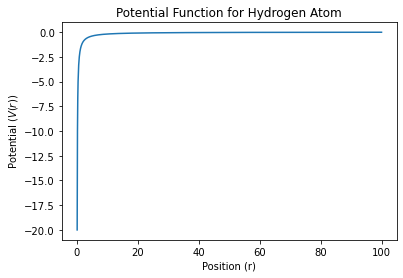

In [7]:
def pot_spher(r, l):
    """
    Hydrogen atom potential, takes spatial points r (must be positive) and orbital quantum number l. Returns a potential at every point in r for a specified l.
    """
    epsilon = sys.float_info.epsilon
    return list(map(lambda r: (-2 /(r)) + l*(l+1) / ((r)**2) , r)) #returning the potential list for a given radius using map()
    
radii = np.linspace(0.1, 100, 1000)
plt.title("Potential Function for Hydrogen Atom")
plt.xlabel("Position (r)")
plt.ylabel("Potential ($V(r)$)")
plt.plot(radii, pot_spher(radii, 0)) #plot of the potential, can clearly see that potential tends to negative infinity as r tends to 0
plt.show()



Now re-use the `hamiltonian()` function to generate the Hamiltonian matrix for the Hydrogren atom, and find at least the first 5 eigenvalues for at least l=0. Compare these eigenvalues with the expected eigenvalues.

|| [n] || Eigenvalue  || Theoretical ||
||  1  || -0.9973110  ||  -1.00000   ||
||  2  || -0.2498188  ||  -0.25000   ||
||  3  || -0.1110728  ||  -0.11111   ||
||  4  || -0.0624871  ||  -0.06250   ||
||  5  || -0.0399944  ||  -0.04000   ||
||  6  || -0.0277749  ||  -0.02778   ||
||  7  || -0.0204065  ||  -0.02041   ||
||  8  || -0.0156238  ||  -0.01562   ||
||  9  || -0.0123142  ||  -0.01235   ||


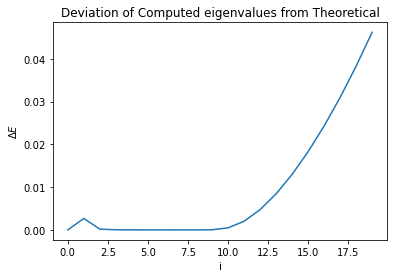

In [8]:
rs = np.linspace(0.00001, 200,  2000) 

def solve_spherical(r, v):
    """
    Solves the hamiltonian in the hydrogen atom case. This function is now the same as the SolveHam function, but originally i thought the normalisation conditions would be different and i thought i'd      have to use a different scipy routine to solve.
    """
    dr = r[1] - r[0]
    spher_evals, spher_evects = linalg.eigh(hamiltonian(r, v))

    index = np.argsort(spher_evals)
    spher_evals = spher_evals[index]
    spher_evects = spher_evects[:, index]

    NormSpher = np.zeros_like(spher_evects)
    for i in range(len(r)):
        norm = integrate.simps(spher_evects[:,i]**2, dx = dr)
        NormSpher[:,i] = spher_evects[:,i]/np.sqrt(norm)
    return spher_evals, NormSpher

s_evals, s_evects = solve_spherical(rs, pot_spher(rs, l = 0))


print("{:<8} {:<8} {:<8}".format("|| [n] ||", "Eigenvalue", " || Theoretical ||"))
n = 20
theo = np.arange(0,n,1)
eval_numbers = np.arange(0, n, 1)
error = np.zeros(n)
for i in range(1,10):
    print('||','{:^3}'.format(eval_numbers[i]),'||','{:^9}'.format("%.7f"%s_evals[i])," || ", '{:^9}'.format( "%.5f"%(-1/theo[i]**2)), ' ||') #tabulating the eigenvalues
for i in range (1,n):
    error[i] = np.abs(s_evals[i] - -1/theo[i]**2) #error in the eigenvalues -> shows the deviation from true theoretical values
xs = [i for i in range(n)]


plt.title("Deviation of Computed eigenvalues from Theoretical")
plt.xlabel("i")
plt.ylabel('$\Delta E$')
plt.plot(xs, error)
plt.show()

    


Finally, as for the quantum harmonic oscillator, plot the wavefunctions.

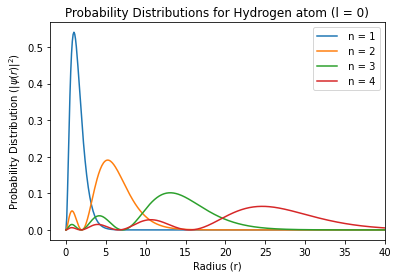

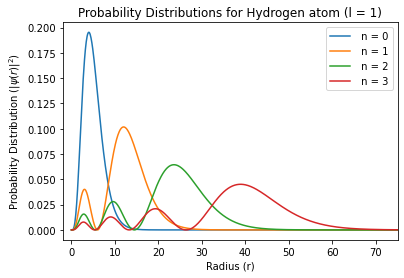

In [9]:
#plt.ylim(0, 1)
def plot_spherical(n, max_r, l):
     """
     Plotting function for Hydrogen atom wavefunctions
     """
     s_evals, s_evects = solve_spherical(rs, pot_spher(rs, l))
     plt.xlim(-2, max_r)
     plt.xlabel('Radius (r)')
     plt.ylabel('Probability Distribution ($|\psi(r)|^2$)')
    
     for i in range(1,n):
          if l ==0:
               plt.plot(rs, s_evects[:,i]**2, label = " n = %s" %i)
               plt.title('Probability Distributions for Hydrogen atom (l = 0)')
          elif l>0: 
               plt.plot(rs, s_evects[:,i-1]**2, label = " n = %s" %(i-1))
               plt.title('Probability Distributions for Hydrogen atom (l = %s)'%l)
     plt.legend()
     plt.show()
plot_spherical(5, max_r=40, l=0)
plot_spherical(5, max_r = 75, l = 1)




# Part 5

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

We were tasked to solve the 1-D Schrodinger equation via the finite difference method of approximating the laplace operator. We first had to write functions for the potential in both the quantum harmonic oscillator and hydrogen atom case. This was done using the map() function, which is faster than the standard 'for loop'. The hamiltonian function then had to be written, this can be done several ways, but scipy's sparse.diags is fast and efficient in generating the matrix, especially for large matrices. 
To solve the hamiltonian, i employ the linalg.eigh routine from scipy to compute the eigenvalues and eigenvectors in a tuple. I use .eigh over .eig as our matrices are hermitian in both cases and .eigh is faster over .eig, as it uses a divide and conquer algorithm, while .eig is intended for general matrices, and uses a slower algorithm. To show the probability distributions, the eigenvectors needed to be normalised, which was done via the integrate.simps method, which uses simpsons rule to approximate the integral. (.simps) is used over (.trapz) as it has a lower error associated, with little to no additional computational cost.
 
${\underline{\text{Results}}}$

The eigenvalues computed are in good agreement with the theoretical values, up to 3 decimal points. The accuracy of the results increasing with increased number of points in the spatial point array. In the Hydrogen atom case, the computed eigenvalues start to deviate beyond the 10th eigenvalue, as shown in cell 8.

The eigenvectors for both the hydrogen atom and quantum harmonic oscillator look as expected. In the hydrogen atom case, the first eigenvector is omitted from the plots as it is a singular spike that is significantly larger than the others. This is due to the potential term as  $V$ tends to $-\infty$ as $r$ tends to 0. 


